<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Выбор локации для скважины

Для добывающей компании нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищем месторождения, для каждого определяем значения признаков
- Строим модели и оцениваем объём запасов
- Выбираем месторождения с самыми высокими оценками значений (количество месторождений зависит от бюджета компании и стоимости разработки одной скважины)
- Прибыль равна суммарной прибыли отобранных месторождений

## Загрузка и подготовка данных

In [1]:
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np
from numpy.random import RandomState

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle

from scipy import stats as st

In [2]:
try:
    data_1 = pd.read_csv('/datasets/geo_data_0.csv')
    data_2 = pd.read_csv('/datasets/geo_data_1.csv')
    data_3 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_1 = pd.read_csv('datasets/geo_data_0.csv')
    data_2 = pd.read_csv('datasets/geo_data_1.csv')
    data_3 = pd.read_csv('datasets/geo_data_2.csv')

Теперь у нас есть три датафрейма с данными о пробах нефти в трех регионах, изучим общую информацию о них.

In [3]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Каждый датасет содержит информацию о 10000 месторождений, пропусков в данных нет.

В каждом датасете 5 столбцов:
- id — уникальный идентификатор скважины
- f0, f1, f2 — три признака точек (количественные)
- product — объём запасов в скважине (тыс. баррелей)

Также проверим наличие дубликатов в данных.

In [6]:
data_1.duplicated().sum()

0

In [7]:
data_2.duplicated().sum()

0

In [8]:
data_3.duplicated().sum()

0

Явные дубликаты не обнаружены.

Столбец с id нам не нужен, он не влияет на целевой признак. Так что удалим его.

In [9]:
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)
data_3 = data_3.drop('id', axis=1)

Изучим распределение данных по объему продукта в каждом регионе, построим гистограммы.

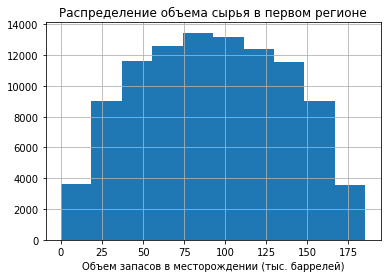

In [10]:
data_1['product'].hist()
plt.title('Распределение объема сырья в первом регионе')
plt.xlabel('Объем запасов в месторождении (тыс. баррелей)')
plt.show()

На гистограмме для первого региона видно нормальное распределение. Судя по графику, в среднем запас в скважине около 90 тыс баррелей. Месторождений с небольшими запасами (до 20 тыс баррелей) довольно мало, с очень большими (более 165 тыс баррелей) тоже совсем не много. Данные выглядят правдоподобно.

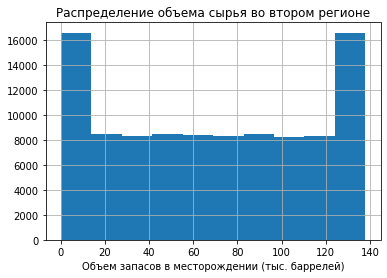

In [11]:
data_2['product'].hist()
plt.title('Распределение объема сырья во втором регионе')
plt.xlabel('Объем запасов в месторождении (тыс. баррелей)')
plt.show()

Во втором регионе распределение данных по объему запасов выглядит необычно. В этом регионе очень много (более 16 тыс.) скважин с совсем небольшими запасами сырья (до 15 тыс баррелей) и также много месторождений с большими запасами (около 125-140 тыс баррелей), а в остальном (скважины с запасом от 15 до 125 тыс баррелей) - плато, данные распределены равномерно.

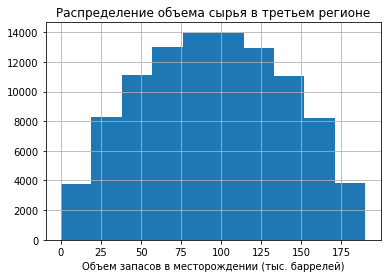

In [12]:
data_3['product'].hist()
plt.title('Распределение объема сырья в третьем регионе')
plt.xlabel('Объем запасов в месторождении (тыс. баррелей)')
plt.show()

На гистограмме по данным из третьего региона видно нормальное распределение. Также как и в первом регионе - скважин с маленькими или очень большими запасами мало, в среднем в месторождении около 90 тыс баррелей.

Далее проверим, есть ли зависимости между признаками с помощью тепловой карты корреляции Пирсона.

Для первого региона:

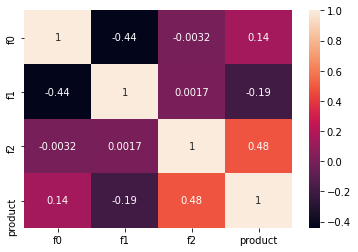

In [13]:
sns.heatmap(data_1.corr(), annot=True);

Тепловая карта по данным из первого региона показала наличие линейной зависимости (коэффициент корреляции 0.44) признаков f0 и f1. Также можно заметить, что объем запасов сильнее всего зависит от признака f2 (коэффициент корреляции 0.48).

Для второго региона:

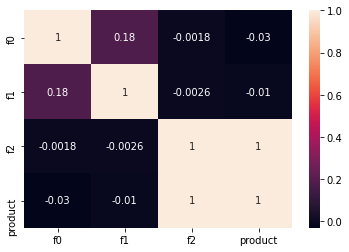

In [14]:
sns.heatmap(data_2.corr(), annot=True);

Во втором регионе сразу заметна прямая взаимосвязь признака f2 и запасов сырья (коэффициент корреляции = 1), кажется, что признаки f0 и f1 совсем не влияют на целевой признак. Но, вероятно, что связь целевого признака и признаков f0, f1 не линейная, поэтому коэффициент корреляции примерно равен нулю, так как он показывает только линейную связь.

Для третьего региона:

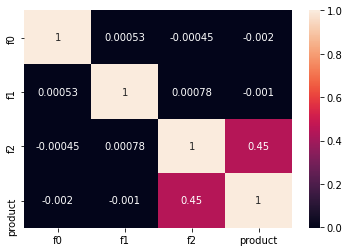

In [15]:
sns.heatmap(data_3.corr(), annot=True);

В третьем регионе также видна взаимосвязь признака f2 и целевого признака, но коэффициент корреляции уже значительно ниже (0.45). Признаки f0, f1, f2 не имеют линейной зависимости.

### Вывод

Итак, данные подготовлены к работе. Что было сделано:

- Сначала были созданы три датафрейма, изучены.
- Данные проверены на явные дубликаты
- Удален столбец id, так как он не нужен для решения поставленной задачи.
- Построены гистограммы распределения целевого признака product
- Построены тепловые карты корреляции Пирсона для данных по трем регионам.

## Обучение и проверка модели

Разделим данные на признаки и целевой признак, а также на выборки: обучающую и валидационную.

In [16]:
features_1 = data_1.drop('product', axis=1)
features_2 = data_2.drop('product', axis=1)
features_3 = data_3.drop('product', axis=1)

target_1 = data_1['product']
target_2 = data_2['product']
target_3 = data_3['product']

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=0.25, 
                                                                                      random_state=12345)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=0.25, 
                                                                                      random_state=12345)

features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(features_3, target_3, test_size=0.25, 
                                                                                      random_state=12345)

Теперь у нас есть обучающая и валидационная выборки для каждого региона.

Проверим размер нескольких выборок, правильно ли поделены данные.

In [17]:
features_train_1.shape

(75000, 3)

In [18]:
features_valid_1.shape

(25000, 3)

In [19]:
target_train_2.shape

(75000,)

In [20]:
target_valid_3.shape

(25000,)

Данные поделены верно.

Также нужно масштабировать количественные признаки f0, f1, f2, так как они могут иметь разный разброс значений, из-за чего во время обучения модель может принять какие-то из них как более важные, что исказит результаты предсказаний. Сделаем это с помощью стандартизации данных.

In [21]:
pd.options.mode.chained_assignment = None

scaler_1 = StandardScaler()
scaler_1.fit(features_train_1)

scaler_2 = StandardScaler()
scaler_2.fit(features_train_2)

scaler_3 = StandardScaler()
scaler_3.fit(features_train_3)

features_train_1 = scaler_1.transform(features_train_1)
features_train_2 = scaler_2.transform(features_train_2)
features_train_3 = scaler_3.transform(features_train_3)

features_valid_1 = scaler_1.transform(features_valid_1)
features_valid_2 = scaler_2.transform(features_valid_2)
features_valid_3 = scaler_3.transform(features_valid_3)

Создадим и обучим модель линейной регрессии для данных из каждого региона.

In [22]:
model_1 = LinearRegression(n_jobs=-1)
model_2 = LinearRegression(n_jobs=-1)
model_3 = LinearRegression(n_jobs=-1)

model_1.fit(features_train_1, target_train_1)
model_2.fit(features_train_2, target_train_2)
model_3.fit(features_train_3, target_train_3)

LinearRegression(n_jobs=-1)

У нас есть три обученные модели для трех датасетов. Теперь получим предсказания

In [23]:
def get_predict(features, target, model):
    predictions = model.predict(features)
    answers = target.reset_index(drop=True)
    rmse = mean_squared_error(answers, predictions) ** 0.5
    return round(predictions.mean(), 2), round(rmse, 2), answers, predictions

In [24]:
mean_1, rmse_1, answers_1, predictions_1 = get_predict(features_valid_1, target_valid_1, model_1)
print('Средний запас предсказанного сырья в первом регионе:', mean_1)
print('RMSE предсказаний по данным из первого региона:', rmse_1)
print()

mean_2, rmse_2, answers_2, predictions_2 = get_predict(features_valid_2, target_valid_2, model_2)
print('Средний запас предсказанного сырья во втором регионе:', mean_2)
print('RMSE предсказаний по данным из второго региона:', rmse_2)
print()

mean_3, rmse_3, answers_3, predictions_3 = get_predict(features_valid_3, target_valid_3, model_3)
print('Средний запас предсказанного сырья в третьем регионе:', mean_3)
print('RMSE предсказаний по данным из третьего региона:', rmse_3)
print()

Средний запас предсказанного сырья в первом регионе: 92.59
RMSE предсказаний по данным из первого региона: 37.58

Средний запас предсказанного сырья во втором регионе: 68.73
RMSE предсказаний по данным из второго региона: 0.89

Средний запас предсказанного сырья в третьем регионе: 94.97
RMSE предсказаний по данным из третьего региона: 40.03



### Вывод

Средние запасы сырья по предсказанным данным (тыс. баррелей):
- в первом регионе: 92.59
- во втором регионе: 68.73
- в третьем регионе: 94.97

Среднеквадратичная ошибка (RMSE) — это метрика, используемая для оценки работы модели регрессии. Этот показатель говорит, насколько точны наши прогнозы и какова величина отклонения от фактических значений.

Как видно по результатам RMSE:
- для первого региона: 37.58
- для второго региона: 0.89
- для третьего региона: 40.03

У первого и третьего регионов значение метрики высокое (37-40). Получается, что прогнозы для этих регионов нельзя назвать точными, скорее наоборот - совсем не точными. Отклонения от фактических значений довольно большие. А у второго региона тем временем метрика показала высокую точность, так как отклонения от реальных значений минимальны (0.89).

Средние запасы сырья по предсказанным данным у первого и третьего регионов выше, чем у второго (92-94 против 68). Но доверять этим данным нельзя, так как метрика RMSE показала, что предсказания моделей первого и третьего регионов далеки от правды. 

## Подготовка к расчёту прибыли

Сохраним ключевые значения для расчётов в отдельных переменных.

In [25]:
POINTS_NUMBER = 500
BEST_POINTS_NUMBER = 200
BUDGET = 10**10
PRICE = 450_000
ITERATIONS_BOOTSTRAP = 1000

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [26]:
budget_one_point = BUDGET / BEST_POINTS_NUMBER
min_volume = budget_one_point / PRICE
print('Необходимый минимальный объем сырья в разработанной скважине:', round(min_volume, 2), 'тыс. баррелей.')

Необходимый минимальный объем сырья в разработанной скважине: 111.11 тыс. баррелей.


Итак, нашли минимальное среднее количество продукта в месторождениях региона, достаточное для разработки. В каждой разработанной скважине должен быть запас минимум 111.11 тыс. бареллей сырья, чтобы она была безубыточна.

Если посмотреть на средние результаты объема сырья в скважинах регионов: в первом регионе: 92.59, во втором регионе: 68.73, в третьем регионе: 94.97, то кажется, что в среднем скважины не имеют достаточно продукта для безубыточности. Но для разработки выбирают 500 скважин, из которых в итоге выбираются 200 лучших. Таким образом среднее значение объема для скважин всего региона некорректно сравнивать, ведь для разработки выбираются точки с лучшими показателями из выборки.

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

- Выберем скважины с максимальными значениями предсказаний
- Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям
- Рассчитаем прибыль для полученного объёма сырья

In [27]:
def profit(target, predictions, count=BEST_POINTS_NUMBER, budget=BUDGET, price=PRICE):
    BEST_points = pd.Series(predictions).sort_values(ascending=False).head(200)
    BEST_points_real = target.iloc[BEST_points.index]
    return BEST_points_real.sum() * price - BUDGET

### Вывод

Итак, подготовились к расчету прибыли. У нас есть константы всех необходимых значений, благодаря которым найдено минимальное среднее количество продукта в месторождениях региона, чтобы месторождение было безубыточным: **111.11 тыс. баррелей**. Это значение больше, чем средние значения объема продукта в скважине по регионам, но надо учитывать тот факт, что разрабатываться будут только месторождения с наибольшим объемом сырья.

Также создана функция **profit** для расчета прибыли по выбранным для разработки 200 скважинам.

## Расчёт прибыли и рисков 

Воспользуемся созданной функцией для подсчета прибыли, создадим список со значениями прибыли после разработки лучших 200 из 500 месторождений. Выборки месторождений собираются случайно. Таким образом всего 1000 выборок по 500 месторождений получены с помощью процедуры Bootstrap.

In [28]:
state = np.random.RandomState(12345)

values_1 = []

for i in range(ITERATIONS_BOOTSTRAP):
    target_subsample_1 = pd.Series(answers_1).sample(n=POINTS_NUMBER, replace=True, random_state=state)
    pred_subsample_1 = predictions_1[target_subsample_1.index]
    prof_1 = profit(target_subsample_1, pred_subsample_1)
    values_1.append(prof_1)

Теперь у нас есть список с прибылью для каждой из 1000 выборок, собранных из данных первого региона. Найдем 2.5% квантиль, 95% доверительный интервал и среднюю прибыль.

In [29]:
values_1 = pd.Series(values_1)
lower_1 = values_1.quantile(0.025)
confidence_interval_1 = st.t.interval(0.95, len(values_1)-1, loc=values_1.mean(), scale=values_1.sem())
print('Первый регион')
print('Средняя прибыль:', round((values_1.mean()/10**6), 2), 'млн руб')
print('Вероятность убытков:', st.percentileofscore(values_1, 0), '%')
print('95% доверительный интервал:', confidence_interval_1)

Первый регион
Средняя прибыль: 396.16 млн руб
Вероятность убытков: 6.9 %
95% доверительный интервал: (379620315.1479725, 412709654.45676965)


Итак, средняя прибыль от разработки скважин в первом регионе примерно 396 млн руб

Получается, что 95% выборок месторождений из первого региона в итоге дают прибыль примерно от 379 млн руб до 412 млн руб. 

Риск получить убыток в этом регионе - 6.9%, значительно больше порога в 2.5%. 

Следовательно, первый регион нам не подходит, слишком велик риск получить убытки вместо прибыли.

In [30]:
values_2 = []
for i in range(1000):
    target_subsample_2 = pd.Series(answers_2).sample(n=500, replace=True, random_state=state)
    pred_subsample_2 = predictions_2[target_subsample_2.index]
    prof_2 = profit(target_subsample_2, pred_subsample_2)
    values_2.append(prof_2)

In [31]:
values_2 = pd.Series(values_2)
lower_2 = values_2.quantile(0.025)
confidence_interval_2 = st.t.interval(0.95, len(values_2)-1, loc=values_2.mean(), scale=values_2.sem())
print('Второй регион')
print('Средняя прибыль:', round((values_2.mean()/10**6), 2), 'млн руб')
print('Вероятность убытков:', st.percentileofscore(values_2, 0), '%')
print('95% доверительный интервал:', confidence_interval_2)

Второй регион
Средняя прибыль: 461.16 млн руб
Вероятность убытков: 0.7 %
95% доверительный интервал: (448828936.4815785, 473482698.07290083)


Средняя прибыль во втором регионе - примерно 461 млн руб, выше чем в первом.

С 95% вероятностью при разработке месторождений из второго региона удастся получить прибыль от 448 до 473 млн руб.

Вероятность получить убыток - 0.7%, значительно меньше порога в 2.5%, значит второй регион нам подходит.

In [32]:
values_3 = []
for i in range(1000):
    target_subsample_3 = pd.Series(answers_3).sample(n=500, replace=True, random_state=state)
    pred_subsample_3 = predictions_3[target_subsample_3.index]
    prof_3 = profit(target_subsample_3, pred_subsample_3)
    values_3.append(prof_3)

In [33]:
values_3 = pd.Series(values_3)
lower_3 = values_3.quantile(0.025)
confidence_interval_3 = st.t.interval(0.95, len(values_3)-1, loc=values_3.mean(), scale=values_3.sem())
print('Третий регион')
print('Средняя прибыль:', round((values_3.mean()/10**6), 2), 'млн руб')
print('Вероятность убытков:', st.percentileofscore(values_3, 0), '%')
print('95% доверительный интервал:', confidence_interval_3)

Третий регион
Средняя прибыль: 392.95 млн руб
Вероятность убытков: 6.5 %
95% доверительный интервал: (376164225.32954943, 409736725.0116595)


Средняя прибыль в третьем регионе - примерно 392 млн руб, примерно равна среднему значению прибыли в первом регионе.

С 95% вероятностью при разработке месторождений из третьего региона удастся получить прибыль от 376 до 409 млн руб, что также примерно равно значениям из первого региона.

Вероятность получить убытки равна 6.5%, что больше порога в 2.5%, значит регион не подходит для целей исследования.

На основе полученных результатов для разработки рекомендуется **второй регион**, так как он с наибольшей вероятностью будет наиболее прибыльным (95% прибыль от 448 до 473 млн руб), а риск убытков минимальный, 0.7%. А также среднее значение прибыли самое высокое среди регионов - 461 млн руб.

## Общий вывод

Итак, проведено исследование данных о месторождениях нефти для добывающей компании. Данные содержали информацию, а именно данные о качестве нефти и объеме запасов, по трем регионам, в каждом по 10000 точек. 

Шаги работы:

**1. Загрузили и подготовили данные:** 

1. Созданы три датафрейма
2. Изучена общая информация
3. Данные проверены на явные дубликаты, дубликаты не обнаружены
4. Удален столбец id, так как он не нужен для решения поставленной задачи
5. Построены гистограммы распределения целевого признака product
6. Построены тепловые карты корреляции Пирсона для данных по трем регионам

**2. Обучили и проверили модель для каждого региона:**

1. Разбили данные на обучающую и валидационную выборки в соотношении 75:25
2. Обучили модель и сделали предсказания на валидационной выборке
3. Сохранили предсказания и правильные ответы на валидационной выборке
4. Подсчитали средний запас предсказанного сырья

- в первом регионе: 92.59 тыс. баррелей
- во втором регионе: 68.73 тыс. баррелей
- в третьем регионе: 94.97 тыс. баррелей

5. Нашли значения метрики RMSE модели.(Среднеквадратичная ошибка (RMSE) — это метрика, используемая для оценки работы модели регрессии. Этот показатель говорит, насколько точны наши прогнозы и какова величина отклонения от фактических значений.)

- для первого региона RMSE: 37.58
- для второго региона RMSE: 0.89
- для третьего региона RMSE: 40.03

У первого и третьего регионов значение метрики RMSE высокое (37-40). Значит предсказания не точные, отклонения от фактических значений высоки. Для данных второго региона метрика показала высокую точность, так как отклонения от реальных значений минимальны (0.89).

Средние запасы сырья по предсказанным данным у первого и третьего регионов выше, чем у второго (92-94 против 68). Но доверять этим данным нельзя, так как метрика RMSE показала, что предсказания моделей первого и третьего регионов не точны.


**3. Подготовились к расчёту прибыли:**

1. Все ключевые значения для расчётов сохранили в отдельных константных переменных
2. Рассчитали достаточный объём сырья для безубыточной разработки новой скважины - 111.11. тыс. баррелей 

Полученное значение больше, чем средние значения объема продукта в скважине по регионам, но надо учитывать тот факт, что разрабатываться будут только месторождения с наибольшим объемом сырья, значит выборка из 200 месторождений для разработки с большой вероятностью будет иметь более высокую среднюю прибыль.

**4. Написали функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели**
1. Выбрали скважины с максимальными значениями предсказаний
2. Просуммировали целевое значение объёма сырья, соответствующее этим предсказаниям
3. Рассчитали прибыль для полученного объёма сырья

Получили функцию profit, принимающую на вход предсказания, действительные значения, число месторождений, по которым будет считаться выборка, а также бюджет и цену за тыс баррелей, которые имеют выставленные дефолтные значения, соответствующие данным из этого исследования: число месторождений - 200, бюджет - 10 млрд. руб, цена за тыс. баррелей - 450 тыс. руб. 

**5. Просчитали риски и прибыль для каждого региона:**
1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. К каждой выборке применялась функция profit для подсчета прибыли
2. Нашли среднюю прибыль, 95%-й доверительный интервал (разброс значений прибыли 95% выборок) и риск убытков (отрицательная прибыль)

Результаты для первого региона:
- средняя прибыль - 396 млн руб
- 95% доверительный интервал - от 379 млн руб до 412 млн руб
- вероятность убытков 6.9%

Результаты для второго региона:
- средняя прибыль - 461 млн руб
- 95% доверительный интервал - от 448 млн руб до 473 млн руб
- вероятность убытков 0.7%

Результаты для третьего региона:
- средняя прибыль - 392 млн руб
- 95% доверительный интервал - от 376 млн руб до 409 млн руб
- вероятность убытков 6.5%

Исходя из результатов, для разработки рекомендуется **второй регион**. Так как 99.3% вероятность того, что будет получена прибыль от разработки этого региона, риск убытков минимален - 0.7%. Также средняя прибыль от месторождений в этом регионе наибольшая из трех регионов, как и значения доверительного интервала.